## Introduction

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv("AmesHousing.txt", delimiter="\t")

## Feature Engineering

- Handle missing values:
    - All columns:
        - Drop any with 5% or more missing values.
    - Text columns:
        - Drop any with 1 or more missing values.
    - Numerical columns:
        - For columns with missing values, fill in with the most common value in that column

1: All columns: Drop any with 5% or more missing values.

In [3]:
## Series object: column name -> number of missing values
num_missing = df.isnull().sum()

In [4]:
# Filter Series to columns containing >5% missing values
drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()

# Drop those columns from the data frame. Note the use of the .index accessor
df = df.drop(drop_missing_cols.index, axis=1)

2: Text columns: Drop any with 1 or more missing values.

In [5]:
## Series object: column name -> number of missing values
text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)

## Filter Series to columns containing *any* missing values
drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]

df = df.drop(drop_missing_cols_2.index, axis=1)

3: Numerical columns: For columns with missing values, fill in with the most common value in that column

In [6]:
## Compute column-wise missing value counts
num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
fixable_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [7]:
## Compute the most common value for each column in `fixable_nmeric_missing_cols`.
replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [8]:
## Use `pd.DataFrame.fillna()` to replace missing values.
df = df.fillna(replacement_values_dict)

In [9]:
## Verify that every column has 0 missing values
df.isnull().sum()

Order              0
PID                0
MS SubClass        0
MS Zoning          0
Lot Area           0
Street             0
Lot Shape          0
Land Contour       0
Utilities          0
Lot Config         0
Land Slope         0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
House Style        0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Roof Style         0
Roof Matl          0
Exterior 1st       0
Exterior 2nd       0
Mas Vnr Area       0
Exter Qual         0
Exter Cond         0
Foundation         0
BsmtFin SF 1       0
BsmtFin SF 2       0
                  ..
Central Air        0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
Kitchen Qual       0
TotRms AbvGrd      0
Functional         0
Fireplaces         0
Garage Cars        0
Garage Area  

Create new features to better capture the information in some of the features

In [10]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [11]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [12]:
## Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

## Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0)

## No longer need original year columns
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

Drop columns that:
- that aren't useful for ML
- leak data about the final sale

In [13]:
## Drop columns that aren't useful for ML
df = df.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

Let's update transform_features()

## Feature Selection

In [14]:
numerical_df = df.select_dtypes(include=['int', 'float'])
numerical_df.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,189900,13,12


In [15]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

In [16]:
## Let's only keep columns with a correlation coefficient of larger than 0.4 (arbitrary, worth experimenting later!)
abs_corr_coeffs[abs_corr_coeffs > 0.4]

BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

In [17]:
## Drop columns with less than 0.4 correlation with SalePrice
transform_df = df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)

Which categorical columns should we keep?

In [18]:
## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

- Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
- If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [19]:
## Which categorical columns have we still carried with us? We'll test tehse 
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

## How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
## Aribtrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis=1)

In [20]:
## Select just the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
## Create dummy columns and add back to the dataframe!
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1)

Creating functions to transform and select features

In [21]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    col_to_drop=df.select_dtypes(['category']).columns
    df.drop(col_to_drop,axis=1,inplace=True)
    return df


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
df=pd.read_csv('AmesHousing.txt',delimiter='\t')
transformed_df=transform_features(df)
new_df=select_features(transformed_df)
X=new_df.drop('SalePrice',axis=1)
y=new_df['SalePrice']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

## Simple Linear Regression

In [23]:
linreg=LinearRegression().fit(X_train,y_train)
score1=linreg.score(X_test,y_test)
score2=linreg.score(X_train,y_train)
print('Simple Linear Regression:')
print('Train set Accuracy score: {:.2f}'.format(score2))
print('Test set Accuracy score: {:.2f}'.format(score1))

Simple Linear Regression:
Train set Accuracy score: 0.90
Test set Accuracy score: 0.90


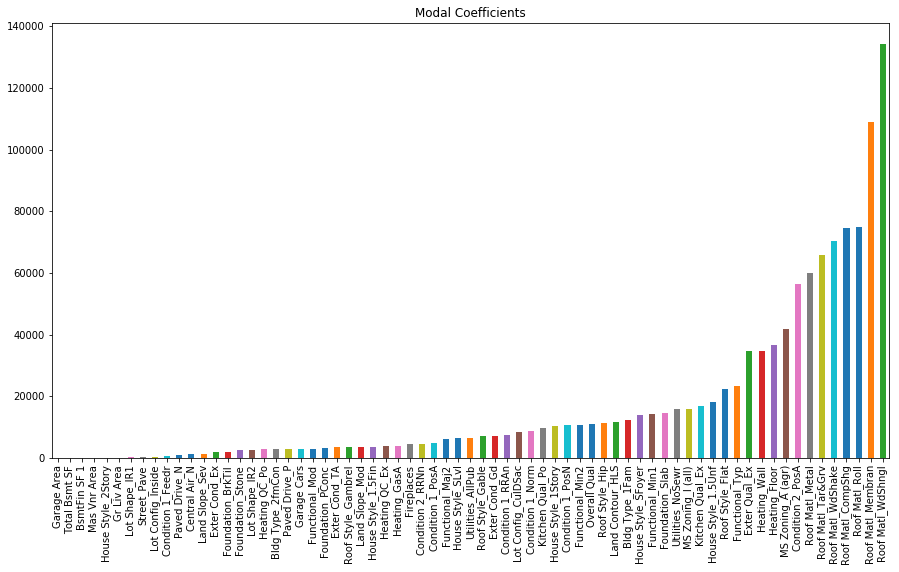

In [24]:
plt.figure(figsize=(15,8))
columns=X_test.columns
coeff=pd.Series(linreg.coef_,columns).sort_values()
coeff_neg=coeff[coeff<0]
coeff_pos=coeff[coeff>0]
coeff_pos.plot(kind='bar', title='Modal Coefficients')


## Ridge Regression

In [25]:
linridge=Ridge(alpha=20).fit(X_train,y_train)
score1=linridge.score(X_test,y_test)
score2=linridge.score(X_train,y_train)
print('Ridge Regression:')
print('Train set Accuracy score: {:.2f}'.format(score2))
print('Test set Accuracy score: {:.2f}'.format(score1))

Ridge Regression:
Train set Accuracy score: 0.88
Test set Accuracy score: 0.89


## Ridge Regression with Normalization

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
linridge=Ridge(alpha=20).fit(X_train_scaled,y_train)
score1=linridge.score(X_test_scaled,y_test)
score2=linridge.score(X_train_scaled,y_train)
print('Normalized Ridge Regression:')
print('Train set Accuracy score: {:.2f}'.format(score2))
print('Test set Accuracy score: {:.2f}'.format(score1))

Normalized Ridge Regression:
Train set Accuracy score: 0.86
Test set Accuracy score: 0.85


## Ridge Regression with Regularization parameter

In [27]:
%matplotlib inline
print('Ridge regression: effect of alpha regularization parameter\n')
alpha=[0.5,1,3,5,10,20]
for this_alpha in alpha:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Ridge regression: effect of alpha regularization parameter

Alpha = 0.50
num abs(coeff) > 1.0: 128, r-squared training: 0.90, r-squared test: 0.89

Alpha = 1.00
num abs(coeff) > 1.0: 128, r-squared training: 0.89, r-squared test: 0.89

Alpha = 3.00
num abs(coeff) > 1.0: 128, r-squared training: 0.88, r-squared test: 0.88

Alpha = 5.00
num abs(coeff) > 1.0: 128, r-squared training: 0.88, r-squared test: 0.87

Alpha = 10.00
num abs(coeff) > 1.0: 128, r-squared training: 0.87, r-squared test: 0.87

Alpha = 20.00
num abs(coeff) > 1.0: 128, r-squared training: 0.86, r-squared test: 0.85



## Lasso Regression with Normalization

In [28]:
linlasso=Lasso(alpha=3.0,max_iter=10000).fit(X_train_scaled,y_train)
train_score=linlasso.score(X_train_scaled,y_train)
test_score=linlasso.score(X_test_scaled,y_test)
print('Lasso Regression with MinMaxScaling:')
print('Train score:{:.3f}'.format(train_score))
print('Test Score: {:.3f}'.format(test_score))

Lasso Regression with MinMaxScaling:
Train score:0.904
Test Score: 0.899
